In [ ]:
from __future__ import print_function, division
from builtins import range, input
import os, sys

In [ ]:
from tensorflow import keras
from keras.models import Model,Sequential
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# 初始狀態設定 config

## 基本序列參數設定

In [ ]:
BATCH_SIZE = 64  # 每一次訓練的批次大小
EPOCHS = 40  # 要訓練幾次
LATENT_DIM = 256  # 編碼空間的潛在維度
NUM_SAMPLES = 10000  #要抓幾行的句子 這邊代表抓1萬翻譯句子
MAX_SEQUENCE_LENGTH = 100 #最大句子長度
MAX_NUM_WORDS = 20000  #最大單字數量，大約兩萬字
EMBEDDING_DIM = 100 #嵌入矩陣的維度

## 創建儲存輸入和輸出序列資料的空list

In [ ]:
input_texts = [] # 用來儲存原始語言的句子
target_texts = [] # 用來儲存翻譯語言的句子
target_texts_inputs = [] # 一樣是儲存翻譯語言的句子，但是會多加上"<SOS>"

# 加載數據以及數據前處理

## 加載翻譯語言的數據
這邊會將cmn.txt的翻譯資料庫加載進來，並且是逐行加載

In [ ]:
t = 0
for line in open('/content/drive/MyDrive/Colab Notebooks/Udemy_Deep Learning: Advanced Natural Language Processing and RNNs/translation_dataset/cmn.txt'):
  # 只保留有限數量的樣本，這邊設為1萬5
  t += 1
  if t > NUM_SAMPLES:
    break

  # 輸入句子和目標句子會被一個tab分開， 也就是\t
  if '\t' not in line:
    continue
  # 分割輸入和翻譯的部分，.rstrip去除尾部的空格部分，.split將每行以\t分割
  input_text, translation, *rest = line.rstrip().split('\t') 

  # 製作目標句子的輸入和輸出格式
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [ ]:
input_texts[0]

'Hi.'

In [ ]:
target_texts[0]

'嗨。 <eos>'

In [ ]:
target_texts_inputs[0]

'<sos> 嗨。'

## 將輸入的句子內的各個單字取出其token
例如apple 對應 1，banana對應2

In [ ]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS) #設定單字數量的上限
tokenizer_inputs.fit_on_texts(input_texts) #將創建的tokenizer的內部參數fit到input_texts上
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts) #將input_texts內的單字使用tokenizer來取出其token

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index #這邊的word to index為一個字典，對應了每個單字對應的數字
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Found 3372 unique input tokens.


In [ ]:
input_sequences[0]

[869]

In [ ]:
word2idx_inputs['hi']

869

In [ ]:
word2idx_inputs

{'i': 1,
 'you': 2,
 'is': 3,
 'a': 4,
 'to': 5,
 'the': 6,
 'tom': 7,
 'he': 8,
 'it': 9,
 'do': 10,
 'me': 11,
 'my': 12,
 'this': 13,
 'have': 14,
 "i'm": 15,
 'are': 16,
 "don't": 17,
 'your': 18,
 'she': 19,
 'we': 20,
 'like': 21,
 'was': 22,
 'that': 23,
 'what': 24,
 'in': 25,
 'of': 26,
 'can': 27,
 'go': 28,
 'not': 29,
 "it's": 30,
 'at': 31,
 'on': 32,
 'how': 33,
 'be': 34,
 'want': 35,
 'for': 36,
 'very': 37,
 'here': 38,
 'did': 39,
 'please': 40,
 'know': 41,
 'him': 42,
 'has': 43,
 'his': 44,
 'good': 45,
 'up': 46,
 "can't": 47,
 'her': 48,
 'they': 49,
 'no': 50,
 "i'll": 51,
 'all': 52,
 'with': 53,
 'now': 54,
 'am': 55,
 'need': 56,
 'an': 57,
 'see': 58,
 'time': 59,
 'think': 60,
 'get': 61,
 'will': 62,
 'come': 63,
 'there': 64,
 "you're": 65,
 'car': 66,
 'why': 67,
 'out': 68,
 'got': 69,
 'help': 70,
 'where': 71,
 'had': 72,
 "that's": 73,
 'home': 74,
 'about': 75,
 'book': 76,
 "he's": 77,
 'work': 78,
 'who': 79,
 'much': 80,
 'too': 81,
 "didn't": 82

In [ ]:
input_sequences[0]

[869]

## 針對輸出目標句子一樣使用tokenizer

In [ ]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='') #這邊的filters是因為我們不希望<sos>、<eos>被過濾，希望他也可以被變成一個token
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) #把兩個list的資料都送進tokenizer去fit參數
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)


Found 8981 unique output tokens.


In [ ]:
word2idx_outputs

{'<eos>': 1,
 '<sos>': 2,
 '汤姆醉了。': 3,
 '坚持。': 4,
 '她只是個孩子。': 5,
 '什么时候开始？': 6,
 '你在看什么？': 7,
 '你和谁说话呢？': 8,
 '我一无所知。': 9,
 '你們好嗎？': 10,
 '学校怎么样？': 11,
 '繼續工作！': 12,
 '?': 13,
 '汤姆不傻。': 14,
 '我全身酸痛。': 15,
 '天快要下雨了。': 16,
 '你認為如何?': 17,
 '我不怕死。': 18,
 '你一定是开玩笑！': 19,
 '我们必须遵守规则。': 20,
 '进来。': 21,
 '再见！': 22,
 '我在家裡。': 23,
 '工作怎么样？': 24,
 '让我试试。': 25,
 '那是什么？': 26,
 '汤姆今年三十岁。': 27,
 '我喜欢跑步。': 28,
 '我想哭。': 29,
 '我累死了。': 30,
 '我头痛。': 31,
 '她在节食中。': 32,
 '她在节食。': 33,
 '我们必须走了。': 34,
 '你們得走了。': 35,
 '你是认真的吗？': 36,
 '他是個好人。': 37,
 '我差不多完成了。': 38,
 '差不多六点了。': 39,
 '你怎么了？': 40,
 '那边有人吗？': 41,
 '你想要什麼?': 42,
 '他和我同岁。': 43,
 '他不能买车。': 44,
 '这太贵了。': 45,
 '我怕死。': 46,
 '春天快來了。': 47,
 '請關上門。': 48,
 '請關門。': 49,
 '汤姆看起来非常开心。': 50,
 '能够出一份力太好了。': 51,
 '他怕那只狗。': 52,
 '我要学法语。': 53,
 '我在树林里迷路了。': 54,
 '我想要的就是这个。': 55,
 '你确定？': 56,
 '冷静点。': 57,
 '走開！': 58,
 '滾！': 59,
 '回家吧。': 60,
 '我生病了。': 61,
 '我很难过。': 62,
 '没关系。': 63,
 '我们知道。': 64,
 '很棒！': 65,
 'dj': 66,
 '。': 67,
 '這是真的。': 68,
 '照顾好自己。': 69,
 '我三十歲。': 70

In [ ]:
target_sequences[0]

[805, 1]

In [ ]:
max_len_target

4

## 對於序列長度小於對大長度的句子進行填充
針對三個序列

encoder_inputs、decoder_inputs、decoder_targets進行填充，其中後兩者需要往後填充，因為要避免decoder先讀到0。

In [ ]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post') #'post'代表往後填充，這樣decoder就不用事先經過一堆0
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 8)
encoder_inputs[0]: [  0   0   0   0   0   0   0 869]
decoder_inputs[0]: [  2 805   0   0]
decoder_inputs.shape: (10000, 4)


## 加載字詞向量
加載glove.6b 100d的字詞向量集，來為上面的所有token取得其代表的向量大小

In [ ]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('/content/drive/MyDrive/Colab Notebooks/Udemy_Deep Learning: Advanced Natural Language Processing and RNNs/glove.6B.100d.txt') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [ ]:
word2vec['hi']

array([ 0.1444  ,  0.23979 ,  0.96693 ,  0.31629 , -0.36064 , -0.87674 ,
        0.098512,  0.31078 ,  0.47929 ,  0.27175 ,  0.30005 , -0.23732 ,
       -0.31517 ,  0.17925 ,  0.61773 ,  0.59821 ,  0.49489 ,  0.3423  ,
       -0.078034,  0.60212 ,  0.18683 ,  0.5207  , -0.12331 ,  0.48313 ,
       -0.24117 ,  0.59696 ,  0.61078 , -0.84414 ,  0.27661 ,  0.068767,
       -1.1388  ,  0.089544,  0.89842 ,  0.53788 ,  0.10841 , -0.10038 ,
        0.12921 ,  0.11476 , -0.474   , -0.8049  ,  0.96    , -0.36602 ,
       -0.43019 , -0.39808 , -0.096782, -0.71184 , -0.31494 ,  0.82346 ,
        0.42179 , -0.69205 , -1.4864  ,  0.29498 , -0.30875 , -0.49995 ,
       -0.4649  , -0.44524 ,  0.8106  ,  1.4757  ,  0.53782 , -0.28271 ,
       -0.045796,  0.14454 , -0.74485 ,  0.35495 , -0.40961 ,  0.35779 ,
        0.40061 ,  0.37339 ,  0.72163 ,  0.40813 ,  0.26155 , -0.14239 ,
       -0.020514, -1.1106  , -0.4767  ,  0.37832 ,  0.89612 , -0.17323 ,
       -0.50137 ,  0.22991 ,  1.5324  , -0.82032 , 

### 嵌入矩陣

In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       [-0.49886   ,  0.76602   ,  0.89750999, ..., -0.41179001,
         0.40538999,  0.78504002],
       ...,
       [ 0.091119  , -0.39875999,  0.30191001, ...,  0.070988  ,
         0.76569003, -0.12167   ],
       [-0.017016  ,  0.10466   ,  0.49697   , ..., -1.01230001,
         0.11587   ,  0.70985001],
       [-0.27663001,  0.55093998,  0.13618   , ..., -0.63821   ,
         1.02839994,  0.053952  ]])

### 嵌入層
作為模型的最一開始的嵌入層

In [ ]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

將解碼器的輸出轉成one-hot形式

In [ ]:
# create targets, since we cannot use sparse categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

In [ ]:
decoder_targets_one_hot[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 創建模型

## Encoder

In [ ]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(LATENT_DIM,return_state=True,dropout=0.3)
encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]

## Decoder

In [ ]:
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(LATENT_DIM,return_sequences=True,return_state=True,dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x,initial_state=encoder_states)

# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## Compile

In [ ]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## fit the model

In [ ]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/40
125/125 [==============================] - 10s 26ms/step - loss: 2.9333 - accuracy: 0.2479 - val_loss: 2.7167 - val_accuracy: 0.2500
Epoch 2/40
125/125 [==============================] - 2s 17ms/step - loss: 2.4880 - accuracy: 0.2500 - val_loss: 2.7965 - val_accuracy: 0.2500
Epoch 3/40
125/125 [==============================] - 2s 17ms/step - loss: 2.3920 - accuracy: 0.2500 - val_loss: 2.8427 - val_accuracy: 0.2500
Epoch 4/40
125/125 [==============================] - 2s 17ms/step - loss: 2.3607 - accuracy: 0.2500 - val_loss: 2.9209 - val_accuracy: 0.2500
Epoch 5/40
125/125 [==============================] - 2s 17ms/step - loss: 2.3089 - accuracy: 0.2500 - val_loss: 2.9245 - val_accuracy: 0.2500
Epoch 6/40
125/125 [==============================] - 2s 17ms/step - loss: 2.2688 - accuracy: 0.2500 - val_loss: 3.0146 - val_accuracy: 0.2500
Epoch 7/40
125/125 [==============================] - 2s 17ms/step - loss: 2.2414 - accuracy: 0.2502 - val_loss: 2.9710 - val_accuracy: 0.250

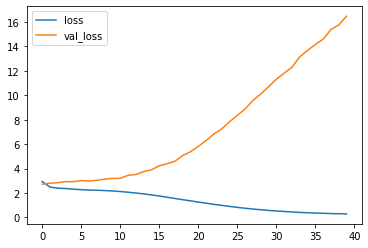

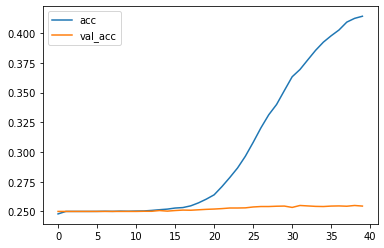

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
# Save model
#model.save('s2s.h5')

# 創建預測模型

In [ ]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)

decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [ ]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)

In [ ]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

1/1 [==============================] - 0s 20ms/step
-
Input: I'm telling you the truth.
Translation: 我會告訴你真相。
Continue? [Y/n]y
1/1 [==============================] - 0s 17ms/step
-
Input: I'm from Boston.
Translation: 他來自波士頓。
Continue? [Y/n]y
1/1 [==============================] - 0s 15ms/step
-
Input: I want to learn how to swim.
Translation: 游泳很簡單。
Continue? [Y/n]y
1/1 [==============================] - 0s 16ms/step
-
Input: Tom was captured.
Translation: 汤姆被囚禁了。
Continue? [Y/n]y
1/1 [==============================] - 0s 20ms/step
-
Input: You've been had.
Translation: 您被骗了。
Continue? [Y/n]y
1/1 [==============================] - 0s 15ms/step
-
Input: It's my birthday soon.
Translation: 我的生日就快到了。
Continue? [Y/n]n
